<a href="https://colab.research.google.com/github/ramanakshay/Optimal-Transport/blob/main/notebooks/dispersion_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Marginal Optimal Transport
1. Sinkhorn Solver
  * Generic Sinkhorn
  * Auto Sinkhorn
  * Random Sinkhorn
2. Multi-marginal Sinhorn on 1D Gaussian Distributions
  * Cost Tensor
  * Visualising the Coupling Tensor
3. Comparison of Running Times

## Import Libraries

In [1]:
!pip install pot  # Pip Installs Packages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
user = 'ramanakshay'
repo = 'Optimal-Transport'

url = f"git+https://github.com/{user}/{repo}.git"
!pip install --upgrade {url}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ramanakshay/Optimal-Transport.git to /tmp/pip-req-build-5jp9pujv
  Running command git clone -q https://github.com/ramanakshay/Optimal-Transport.git /tmp/pip-req-build-5jp9pujv


In [3]:
import numpy as np 

import matplotlib.pyplot as plt # plotting

import ot  # ot
import ot.plot
from prettytable import PrettyTable

from tqdm import tqdm #progress bar
from IPython.display import clear_output

import time # measure time
from numpy import random
import math

In [4]:
from utils.plot import plot_matrix,plot_2d_map
from utils.dist import find_cost_tensor

## Sinkhorn Solver Class

The scaling vectors are stored in a matrix $ U $ of size $ n \times s $. They can be initialised to ones or random values. Three versions of sinkhorn have been implemented:

**Auto Sinkhorn** \\
  Input: ɛ, error, initialisation type \\
  Output: $P$ tensor \\
  Stopping Time:
  $ \left | \sum_{ℕ_{n} - \{i\}}{P - A_{i}} \right | \leq $ error $\space \forall i \in ℕ_{n} $

In [5]:
class SinkhornSolver(object):
  def __init__(self,A,C):
    self.A = A
    self.C = C
    self.n = A.shape[0]
    self.size = A.shape[1]
  
  def initialise(self,initial):
    if (initial == "ones"):
      return np.ones((self.n,self.size))
    elif (initial == "random"):
      return random.rand(self.n,self.size)
    else:
      raise ValueError("Invalid Argument: " + initial + " is not a valid type.")

#-----------------------------HELPER FUNCTIONS---------------------------------#
  def multiply(self,P,U,i):
    shape = [1]*self.n
    shape[i] = self.size
    shape = tuple(shape)
    temp = U[i].reshape(shape)
    return P * temp

  def divide(self,P,U,i):
    shape = [1]*self.n
    shape[i] = self.size
    shape = tuple(shape)
    temp = U[i].reshape(shape)
    return P / temp

  def sum_to_vector(self,P,i):
    axes = list(range(self.n))
    axes.remove(i)
    axes = tuple(axes)
    return np.sum(P,axis = axes)

#--------------------------------AUTO SINKHORN---------------------------------#

  def auto_sinkhorn(self,epsilon,error,initial = "ones"):
    U = self.initialise(initial)
    K = np.exp(-self.C/epsilon)
    P = np.copy(K)

    #initialise P
    for i in range(self.n):
      P = self.multiply(P,U,i)
    
    #loop
    iter = 0
    while(True):
      for i in range(self.n):
        P = self.divide(P,U,i)
        U[i] = self.A[i] / self.sum_to_vector(P,i)
        P = self.multiply(P,U,i)

      #marginal condition
      flag = True
      max_error = -1
      for i in range(self.n):
        if (np.any(abs(self.sum_to_vector(P,i) - self.A[i]) >= error)):
          flag = False
        clear_output(wait = True)
        max_error = max(max_error,np.max(abs(self.sum_to_vector(P,i) - self.A[i])))
      if(flag):
        break

      print("Maximum Error:",max_error)
      print("#Iterations:",iter)
      
      iter += 1

    #return coupling  
    return P,U

## Multi-marginal Sinkhorn on 1D Gaussian Distributions

### Gaussian Distribution

$$ f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left (  \frac{x-R/2}{\sigma}\right )^2} + \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left (  \frac{x+R/2}{\sigma}\right )^2} $$

where $\mu$ is the mean and $\sigma$ is the standard deviation of the distribution.

In [83]:
def gaussian_mix(size,mu,std,scale = None):
  assert len(mu) == len(std)
  if scale == None:
    scale = [1]*len(mu)
  x = np.arange(size, dtype = np.float64)
  h = 0
  for i in range(len(mu)):
    h += np.exp(-(x - mu[i]) ** 2 / (2 * std[i] ** 2))*scale[i]
  return h / h.sum()

def dispersion_density(size,R):
  #assert R <= 10*size/16 and R >= 0
  return gaussian_mix(size,[size//2 + R/2,size//2 - R/2],[size/32,size/32],[1,1])

def uniform_density(size):
  return 1/size * np.ones((size,))

In [84]:
n = 2
size = 500

A = np.empty((n,size), float)
# All marginals are the same
for i in range(n):
  A[i] = dispersion_density(size,300)

x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

In [58]:
n = 3
size = 200

A = np.empty((n,size), float)
# All marginals are the same
for i in range(n):
  A[i] = uniform_density(size)

x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

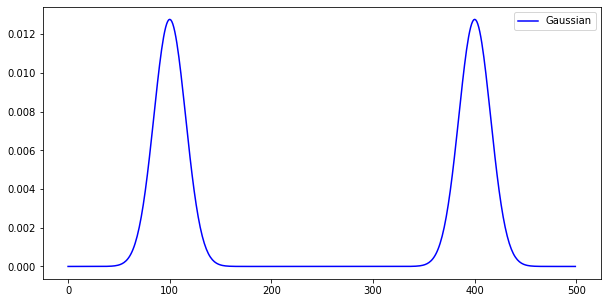

In [85]:
#Plot distributions
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b',label = 'Gaussian')
plt.legend()
plt.show()

### Cost Tensor

$$ C = \sum_{1 \leq i < j \leq n}{\frac {1}{\left | 1 + (r_i - r_j) \right | }} $$

(500, 500)


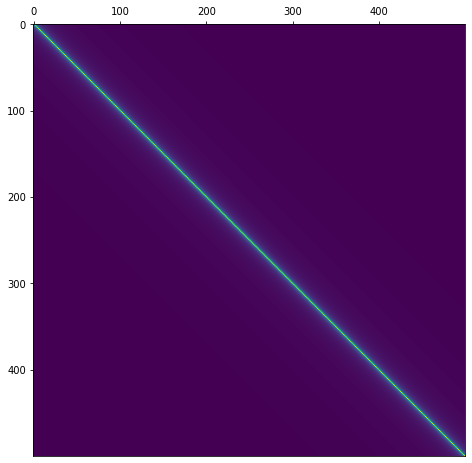

In [86]:
C = find_cost_tensor(X)
print(C.shape)
#Cm = np.sum(C,axis = (2))
plot_matrix(C,x,x)

### Coupling Tensor

In [87]:
solver = SinkhornSolver(A,C)

In [88]:
output=solver.auto_sinkhorn(1e-3,1e-4,initial="random")
P = output[0]
Ae = output[1]
U=-1e-3*np.log(Ae)

In [ ]:
#P = solver.random_sinkhorn(1e-3,1e-6,k = 3,initial="random")

In [ ]:
#P = solver.generic_sinkhorn(10,100)

#### Coupling Projection Matrix

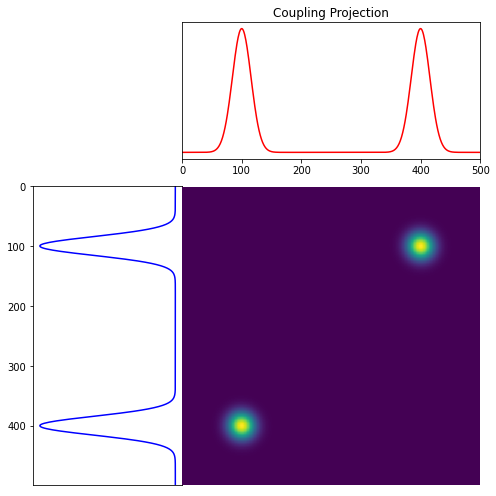

In [90]:
#Pm = np.sum(P,axis = (2))

plt.figure(figsize=(7, 7))
ot.plot.plot1D_mat(A[0], A[1], P, 'Coupling Projection')

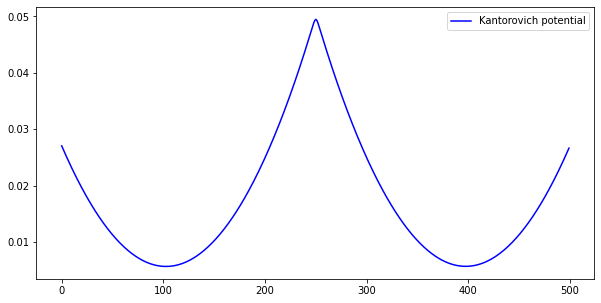

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(x, U[0], 'b',label = 'Kantorovich potential')
plt.legend()
plt.show()

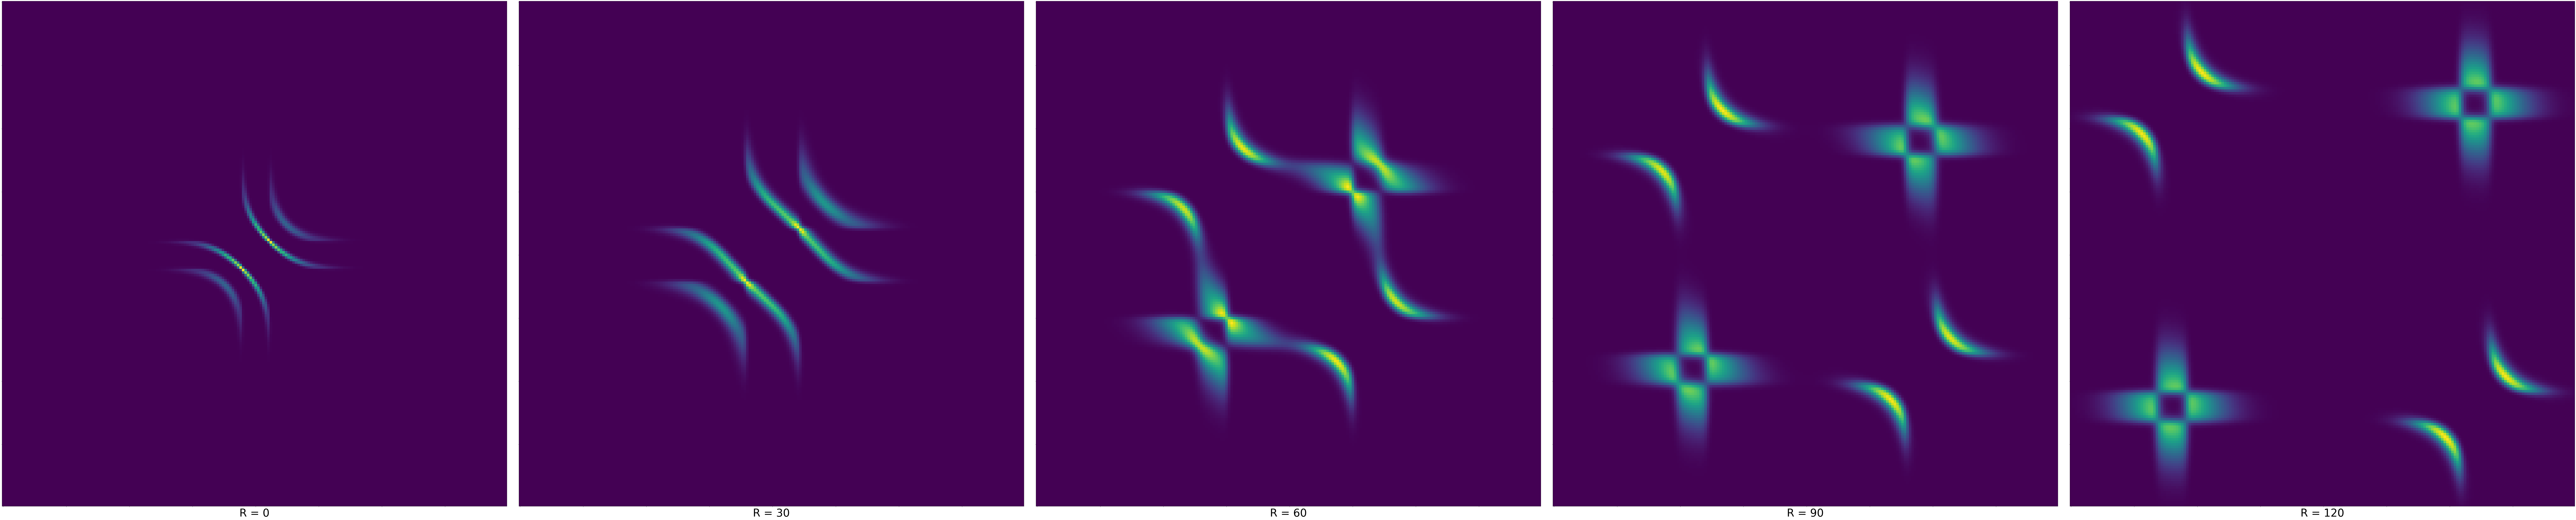

In [8]:
R = 0
n = 3 #number of marginals
size = 200 #size of the space 
x = np.array([[k,] for k in range(size)]) # defining the space
X = np.tile(x.T,(n,1))
C = find_cost_tensor(X)
Cm = np.sum(C,axis = (2))
A = np.empty((n,size), float)
fig, axs = plt.subplots(1, 5, constrained_layout=True)
fig.set_figheight(200)
fig.set_figwidth(200)

i = 0
times = []
for R in [0,30,60,90,120]:
  for j in range(n):
    A[j] = dispersion_density(size,R)
  solver = SinkhornSolver(A,C)
  output=solver.auto_sinkhorn(1e-3,1e-3,initial="random")
  P=output[0]  
  Pm = np.sum(P,axis = (2))
  axs[i].imshow(Pm)
  axs[i].set_xlabel('R = ' + str(R) ,size = 60)
  axs[i].set_xticklabels([])
  axs[i].set_yticklabels([])
  i += 1

TypeError: ignored

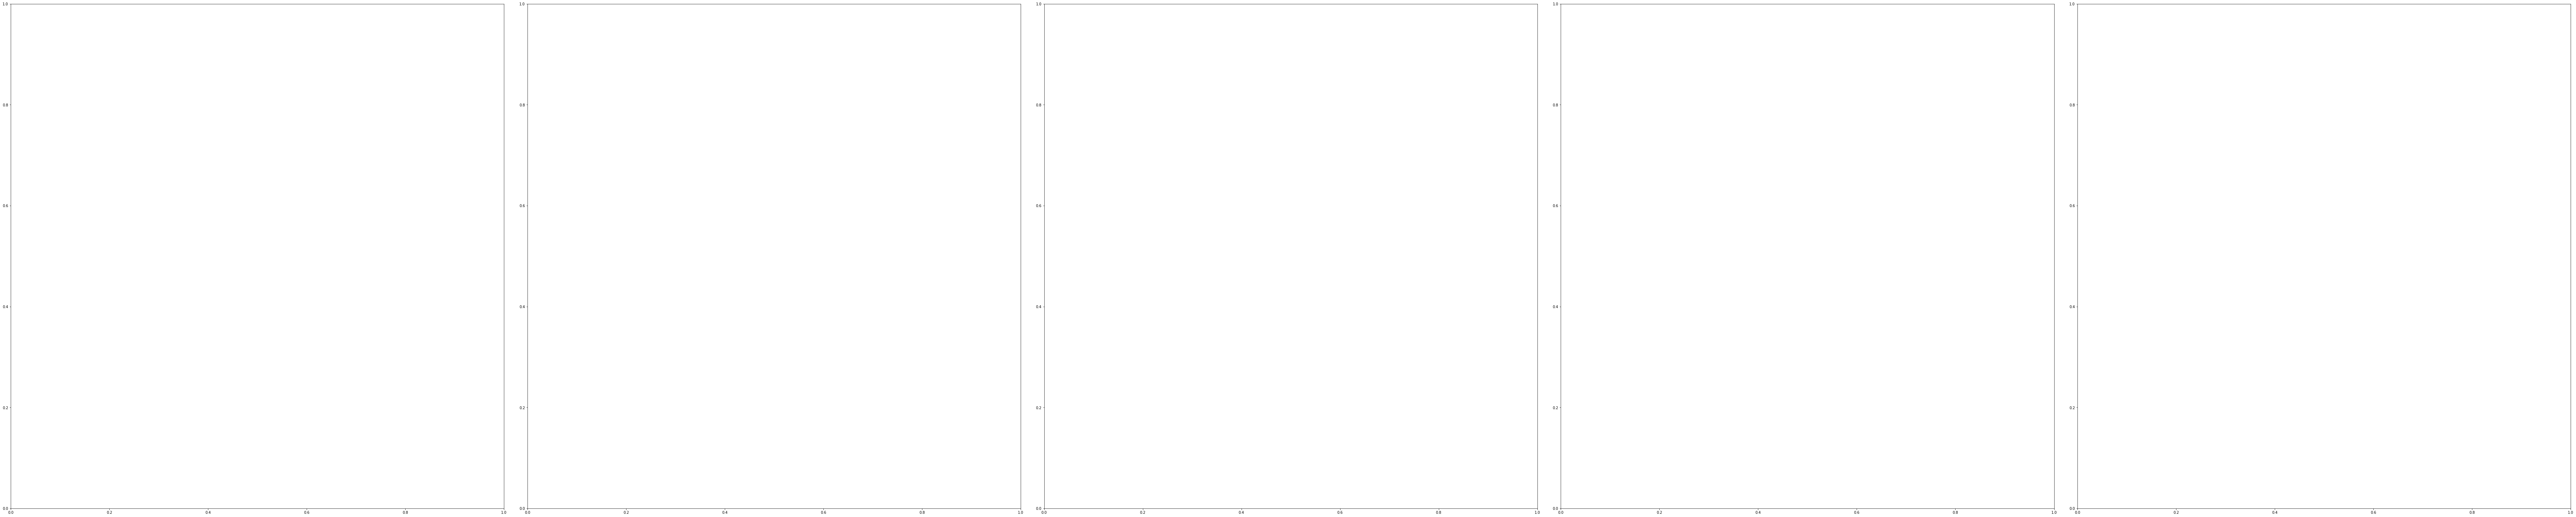

In [57]:
R = 0
fig, axs = plt.subplots(1, 5, constrained_layout=True)
fig.set_figheight(20)
fig.set_figwidth(100)
n = 3 #number of marginals
size = 200 #size of the space
A = np.empty((n,size), float) 
x = np.array([[k,] for k in range(size)]) # defining the space
X = np.tile(x.T,(n,1))
C = find_cost_tensor(X)
Cm = np.sum(C,axis = (2))
i = 0
times = []
for R in [0,30,60,90,120]:
  for j in range(n):
    A[j] = uniform_density(size,R)
  solver = SinkhornSolver(A,C)
  output=solver.auto_sinkhorn(1e-3,1e-3,initial="random")
  Ae = output[1]
  U=1e-3*np.log(Ae)
  axs[i].plot(x, U[0])
  axs[i].set_xlabel('R = ' + str(R) ,size = 60)
  axs[i].set_xticklabels([0,20,40,60,80,100,120,140,160,180,200],size=30)
  #axs[i].set_yticklabels(size=30)
  i += 1

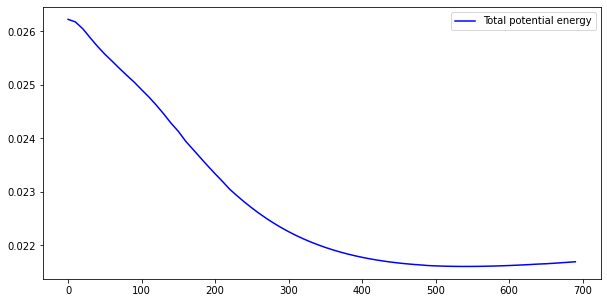

In [93]:
r = [] # R values
y = [] # V values
R=0
N=2 #number of marginals
size=1000
x = np.array([[k,] for k in range(size)]) # defining the space
X = np.tile(x.T,(N,1))
C = find_cost_tensor(X)
A = np.empty((N,size), float)
i=0
for R in range(0,700,10):
  r.append(R)
  for j in range(N):
    A[j] = dispersion_density(size,R)
  solver = SinkhornSolver(A,C)
  output=solver.auto_sinkhorn(1e-3,1e-4,initial="ones")
  P=output[0]
  Ae = output[1]
  U=-1e-3*np.log(Ae)
  K= np.sum(A[0]*U[0])
  V = np.sum(C*P)
  y.append(V+2*K)
plt.figure(figsize=(10, 5))
plt.plot(r, y, 'b',label = 'Total potential energy')
plt.legend()
plt.show()  

### Comparison with anaylitical examples


Consider the particular case of $N=2$ electrons in 1-D described by a one body density like:
\begin{equation}
\rho(x)=\frac{2}{\pi(1+x^2)},
\end{equation}
A lorentzian density.  
For this kind of density we have obtained the exact analytical expression for the kantorovich potential:

\begin{equation}
f(x)= \left\{ \begin{array}{lcc}
             5 &   si  & x \leq 2 \\
             \\ x^2-6x+10 &  si & 2 < x < 5 \\
             \\ 4x-15 &  si  & x \geq 5
             \end{array}
   \right.
\end{equation}
So, we'll compare this solution to the one obtain using the Sinkhorn algortitm.




In [67]:
def Lorentzian(size):
  x = np.arange(size, dtype = np.float64)
  h = 2/(np.pi*(1+pow((x-size/2)*0.05,2)))
  return h / h.sum()

#def Lorentzian(Size):
#  x=[]
#  j=0
#  for i in range(size):    
#    x[i]=j
#    h[i]=2/(1+x[i]*x[i])
#   j += 1
#  return h 

In [75]:
n = 2
size = 200

A = np.empty((n,size), float)
# All marginals are the same
for i in range(n):
  A[i] = Lorentzian(size)
x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

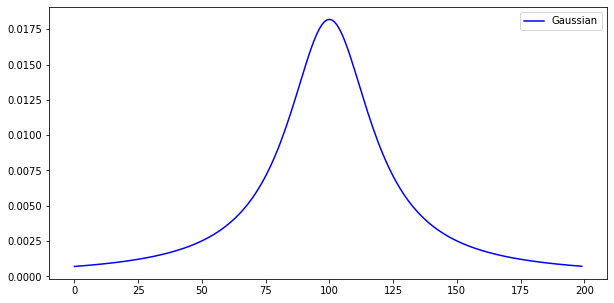

In [76]:
#Plot Lorentzian dentisy distributions
plt.figure(figsize=(10, 5))
plt.plot(x, B[0], 'b',label = 'Gaussian')
plt.legend()
plt.show()

(200, 200)


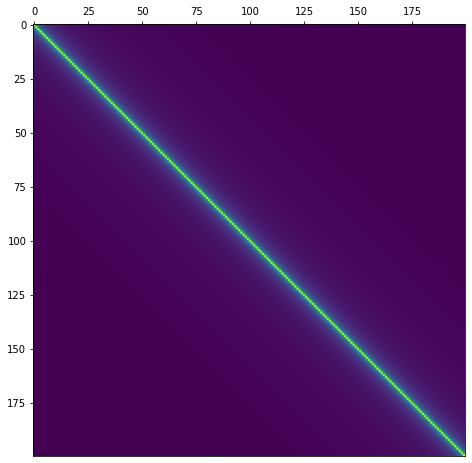

In [78]:
C = find_cost_tensor(X)
print(C.shape)
#Cm = np.sum(C,axis = (2))
plot_matrix(C,x,x)

In [79]:
solver = SinkhornSolver(A,C)

In [80]:
output=solver.auto_sinkhorn(1e-3,1e-4,initial="random")
P = output[0]
Ae = output[1]
U=1e-3*np.log(Ae)

Maximum Error: 0.00010230934814817183
#Iterations: 53


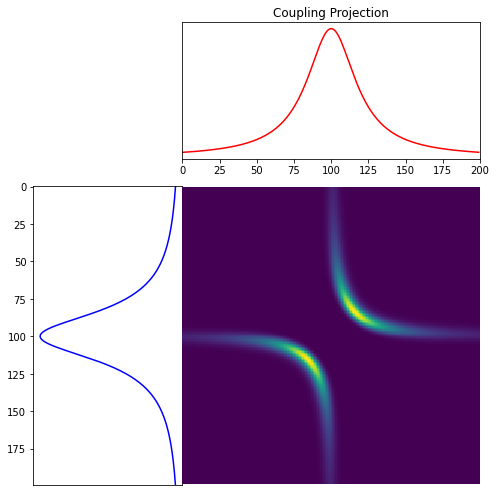

In [81]:
#Pm = np.sum(P,axis = (2))

plt.figure(figsize=(7, 7))
ot.plot.plot1D_mat(A[0], A[1], P, 'Coupling Projection')

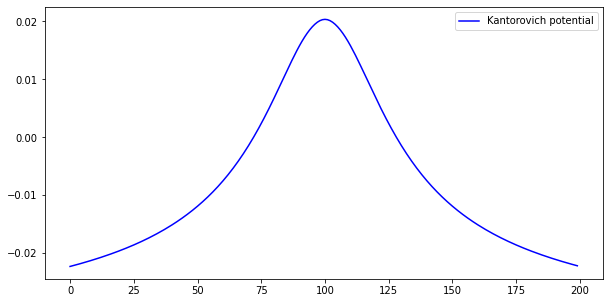

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(x, U[0], 'b',label = 'Kantorovich potential')
plt.legend()
plt.show()

In [ ]:
table = PrettyTable()
table.field_names = ["N", "t(s), eps = 100","t(s), eps = 10","t(s), eps = 1","t(s), eps = 0.1","t(s), eps = 0.01"]

marginals = 5
size = 50
for n in range(2,marginals+1):
  A = np.empty((n,size), float)
  for j in range(n):
    A[j] = gaussian_mix(size,[25],[5],[1])

  x = np.array([[i,] for i in range(size)]) # defining the space
  X = np.tile(x.T,(n,1))

  C = find_cost_tensor(X)

  solver = SinkhornSolver(A,C)

  epsilon = 100
  row = [n]
  while(epsilon >= 0.01):
    start = time.time()
    solver.auto_sinkhorn(epsilon,1e-5,initial="ones")
    end = time.time()
    t = end - start
    row.append(round(t,3))
    clear_output(wait = True)
    epsilon /= 10

  del [A,C,solver] # clear memory
  table.add_row(row)

print(table)